# <p style="padding: 15px; background-color: #778899; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 150%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">Optimal Price Detection</p>

## <p style="padding: 15px; background-color: #778899; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 125%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">1) Importing</p>

### <p style="padding: 15px; background-color: #778899; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">1.1 Installing Libraries</p>

In [5]:
!pip install -r requirements.txt

### <p style="padding: 15px; background-color: #778899; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">1.2 Importing Libraries</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import ast
import time
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit,  train_test_split
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from colorama import Fore, Style


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


warnings.filterwarnings("ignore")


# user prefers a light theme (Change)
user_prefers_light_theme = True

# Set default color based on user preference or any other condition
CLR = Fore.BLACK if user_prefers_light_theme else (Style.BRIGHT + Fore.WHITE)
RED = Style.BRIGHT + Fore.RED
BLUE = Style.BRIGHT + Fore.BLUE
CYAN = Style.BRIGHT + Fore.CYAN

# Matplotlib & Seaborn settings.
FONT_COLOR = "#000"
BACKGROUND_COLOR = "#F6F5F5"
DF_CMAP = sns.light_palette("#252131", as_cmap=True)
MY_RC = {
    "axes.labelcolor": FONT_COLOR,
    "axes.labelsize": 10,
    "axes.labelpad": 15,
    "axes.labelweight": "bold",
    "axes.titlesize": 14,
    "axes.titleweight": "bold",
    "axes.titlepad": 15,
    "xtick.labelsize": 7,
    "xtick.color": FONT_COLOR,
    "ytick.labelsize": 7,
    "ytick.color": FONT_COLOR,
    "figure.titlesize": 14,
    "figure.titleweight": "bold",
    "figure.facecolor": BACKGROUND_COLOR,
    "figure.edgecolor": BACKGROUND_COLOR,
    "figure.dpi": 72,  
    "font.size": 14,
    "font.family": "Serif",
    "text.color": FONT_COLOR,
}

sns.color_palette("hls", 8)
sns.set_theme(rc=MY_RC)


### <p style="padding: 15px; background-color: #778899; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">1.3 Importing Data</p>

In [2]:
original_data = pd.read_csv('data/data.csv')
benchmarked_data = pd.read_csv('data/benchmark_data.csv')

display(original_data, benchmarked_data)

,Long,Lat,Size,Light,Price_Booking1,Price_Booking2,Price_Booking3,Price_Booking4,Price_Booking5,Price_Booking6,...,Price_Booking511,Price_Booking512,Price_Booking513,Price_Booking514,Price_Booking515,Price_Booking516,Price_Booking517,Price_Booking518,Price_Booking519,Price_Booking520
0,5,-54,medium,0,"(25.82068271676904, 0.7519)","(77.29030734504285, 0.1281)","(26.42977169141242, 0.7555)","(62.99594808649998, 0.2545)","(29.367952575023835, 0.7252)","(12.498892405599015, 0.9243)",...,"(15.452548500178054, 0.8098)","(79.16898963165264, 0.108)","(42.128169836948345, 0.4888)","(90.40108811925055, 0.0577)","(95.08379435621892, 0.0434)","(98.59868991395079, 0.0348)","(66.28525118972154, 0.209)","(10.438122191545451, 0.8847)","(65.58403874417343, 0.219)","(67.03639353949687, 0.207)"
1,15,34,large,1,"(60.5614418412558, 0.0441)","(44.09864114154084, 0.1872)","(12.864575260713796, 0.8316)","(22.15931742842302, 0.6385)","(66.75211626816896, 0.0236)","(56.097437492463165, 0.0706)",...,"(36.252092499116415, 0.2932)","(97.94984356954937, 0.0003)","(83.55961793769666, 0.0026)","(46.73238535091752, 0.1442)","(26.315070270634035, 0.5035)","(96.44073701826878, 0.0004)","(8.402180767240308, 0.8583)","(29.320140891961966, 0.448)","(2.347873700296099, 0.9208)","(54.38055023149264, 0.0792)"
2,52,33,small,1,"(64.77841886497515, 0.0978)","(63.79016149960564, 0.1055)","(4.2689974099545775, 0.9454)","(99.1170238991595, 0.0048)","(10.377996166352721, 0.9134)","(18.369220836111012, 0.8119)",...,"(38.22115060567866, 0.3989)","(4.443929498817734, 0.8718)","(94.07931546786537, 0.0075)","(64.28148553268129, 0.0959)","(50.52228570735669, 0.2264)","(86.83656236684291, 0.0155)","(76.91744425841044, 0.0374)","(33.86871398561934, 0.4942)","(0.4159661590927177, 0.9249)","(91.44157368958481, 0.0103)"
3,36,-32,small,0,"(43.51319658191266, 0.5933)","(20.583513389202647, 0.8548)","(51.335440281471314, 0.5031)","(88.96013764481202, 0.1404)","(10.176719125181155, 0.944)","(80.58790465316733, 0.2008)",...,"(65.66340019323884, 0.3075)","(54.79499263500919, 0.4246)","(5.085965871041765, 0.8802)","(98.82202564164659, 0.083)","(59.43480296481752, 0.3801)","(41.154463469789526, 0.5986)","(9.927405560835512, 0.8888)","(95.51171633092292, 0.0999)","(15.3399616599158, 0.8736)","(58.67192259210717, 0.4038)"
4,29,49,medium,0,"(9.023792361018867, 0.9172)","(34.06932873577466, 0.6672)","(42.200420426573835, 0.5574)","(54.54040575218243, 0.3914)","(9.604716563777105, 0.9414)","(12.166224412048997, 0.9314)",...,"(9.335770325450078, 0.8544)","(41.233911400951904, 0.5271)","(62.93835936133358, 0.2676)","(87.14023119112295, 0.0898)","(88.1610349091075, 0.0857)","(38.64205874576124, 0.5754)","(12.61911415987419, 0.8676)","(58.14450114233951, 0.3303)","(62.25082481310573, 0.2868)","(54.831370666551585, 0.3759)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,49,18,medium,0,"(51.057549941522794, 0.4078)","(42.34273725131074, 0.5335)","(31.89555000828581, 0.6892)","(12.644236901508766, 0.9136)","(37.91513028360266, 0.6108)","(35.86318384699948, 0.645)",...,"(40.47251505756966, 0.519)","(22.619057561767043, 0.7479)","(81.20644197620157, 0.1071)","(7.494602874205736, 0.8752)","(50.97230281510361, 0.3902)","(90.72099571313404, 0.0647)","(83.41633267453949, 0.0979)","(91.24883816628775, 0.0637)","(41.07662978123086, 0.5387)","(20.749270852870794, 0.8124)"
9996,-53,5,medium,1,"(42.4095046484702, 0.2688)","(20.660133027478377, 0.7039)","(81.43615514323682, 0.0094)","(69.92758917735364, 0.032)","(90.9934358869999, 0.003)","(44.30783636026238, 0.2483)",...,"(28.049896535433604, 0.5073)","(63.62124496726843, 0.0526)","(35.844509370042, 0.3621)","(33.913182424589706, 0.4001)","(49.42981596965305, 0.1637)","(88.83754809720124, 0.0037)","(1.2420499984977518, 0.9094)","(49.86155801510175, 0.1626)","(97.45792436656976, 0.0012)","(29.63173563178385, 0.5061)"
9997,-8,-32,medium,0,"(98.10451616012415, 0.0649)","(22.423455369724422, 0.824)","(9.490729681265819, 0.9

,Long,Lat,Size,Light,Price_Booking1,Price_Booking2,Price_Booking3,Price_Booking4,Price_Booking5,Price_Booking6,...,Price_Booking511,Price_Booking512,Price_Booking513,Price_Booking514,Price_Booking515,Price_Booking516,Price_Booking517,Price_Booking518,Price_Booking519,Price_Booking520
0,11,-8,small,1,"(44.07422740778878, 0.2244)","(10.235745495054404, 0.8771)","(77.44432192100861, 0.0115)","(32.682854325706636, 0.4374)","(93.07005020369597, 0.0016)","(59.55342009850416, 0.0712)",...,"(3.503511792465819, 0.8693)","(21.207831688891897, 0.6324)","(37.472733112480896, 0.3145)","(17.68477270798783, 0.7076)","(3.9349006656278496, 0.8869)","(90.75592780176181, 0.0021)","(57.12871533905361, 0.082)","(48.73808820675718, 0.1592)","(12.213765932305831, 0.8287)","(50.82865199262406, 0.1387)"
1,-23,50,large,0,"(27.403085749044997, 0.6838)","(67.88625315230517, 0.1343)","(58.481870400767434, 0.224)","(56.95623287755157, 0.2431)","(4.993203977397098, 0.9579)","(42.47182196384385, 0.4534)",...,"(21.379118386361394, 0.7227)","(58.91370302091187, 0.2023)","(4.511084912965702, 0.8782)","(49.94310488165724, 0.3095)","(11.68847681410703, 0.8466)","(69.85385620221606, 0.1142)","(30.52089300740838, 0.6134)","(72.41102332280923, 0.0994)","(39.81837685219315, 0.4723)","(88.06567678260058, 0.0348)"
2,10,-45,medium,0,"(32.49922734531039, 0.6368)","(27.27239937360443, 0.7202)","(36.20418901494742, 0.5888)","(81.40103513141597, 0.0835)","(71.81075706852077, 0.1446)","(18.065003797032787, 0.8636)",...,"(17.42772963166037, 0.7843)","(7.484976054849901, 0.8631)","(25.601585429981, 0.6956)","(50.3850166054486, 0.3494)","(16.117362334552887, 0.8151)","(14.195214120071231, 0.8388)","(44.23375456195849, 0.4425)","(83.32192167215457, 0.0709)","(54.16402788999447, 0.3136)","(25.087128491645018, 0.7394)"
3,-4,3,small,1,"(92.82272915578096, 0.0011)","(24.132065502164757, 0.6006)","(63.09560763988213, 0.0423)","(33.327256606541425, 0.403)","(33.69975089548419, 0.3979)","(73.18542895745563, 0.0147)",...,"(69.74082104797938, 0.0195)","(38.80884537040286, 0.271)","(63.16126548911956, 0.039)","(88.27001407634896, 0.002)","(74.70630932807055, 0.0114)","(92.17872999659934, 0.0012)","(97.04303626476803, 0.0006)","(2.4528886659984206, 0.9133)","(59.1714243644762, 0.0596)","(61.30086613145307, 0.0492)"
4,-2,15,small,1,"(49.80177382910645, 0.1483)","(54.07334498175166, 0.1074)","(45.903234713953736, 0.1989)","(77.4330848736851, 0.0111)","(65.96155090109079, 0.0379)","(5.084813285843259, 0.9554)",...,"(66.97356607076182, 0.0311)","(91.1566259740697, 0.0018)","(85.68419936773684, 0.0037)","(75.55400762308903, 0.0127)","(48.515525854018584, 0.1555)","(60.91412796408466, 0.057)","(39.00983918378642, 0.2932)","(19.47406031706128, 0.6919)","(94.582862203968, 0.0012)","(35.19505761977505, 0.3708)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,54,46,large,0,"(38.92010905514978, 0.6391)","(43.67199655852267, 0.5828)","(79.3108073425907, 0.1922)","(33.835143318405905, 0.7183)","(8.094740680730572, 0.952)","(30.051272039367525, 0.7738)",...,"(16.501405960541682, 0.8184)","(48.548879030391035, 0.4833)","(92.11811494885823, 0.1019)","(25.932470821018295, 0.7508)","(55.42036821166823, 0.4102)","(57.53425442297285, 0.3887)","(50.4710198315531, 0.4757)","(59.57297892738654, 0.3715)","(52.41657965896061, 0.4593)","(84.69875384380687, 0.1499)"
1996,-33,30,small,1,"(63.414821080339145, 0.1132)","(96.5251344234855, 0.007)","(48.693655619087295, 0.274)","(83.48267652523833, 0.0245)","(38.41139224623771, 0.4452)","(35.417629666876074, 0.5032)",...,"(16.825458038755116, 0.7557)","(99.07768920144888, 0.005)","(36.36184221758047, 0.4416)","(86.57729771540193, 0.0172)","(35.933910870024555, 0.4546)","(94.78582147599467, 0.008)","(42.88209797584985, 0.3458)","(87.63162373682749, 0.0161)","(74.36260170592735, 0.0503)","(48.352661829682454, 0.2723)"
1997,32,-44,large,1,"(78.75671906763031, 0.0079)","(85.83768213401827, 0.0032)","(94.06346122190314, 0.001)","(2

## <p style="padding: 15px; background-color: #778899; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 125%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">2) Exploratory Data Analysis</p>

<p style="
    font-size: 26px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #778899;
">
    <b>Notes</b> 📜
</p>

<blockquote style="
    margin-right: auto;
    margin-left: auto;
    background-color:#222;
    padding: 15px;
    border-radius: 8px;
    border-left: none;
">
<ul style="
    font-size: 18px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px;
    margin-bottom: 4px;
">
    <li style='padding-bottom: 10px;'><code>Checking Data:</code> to see NaN values</li>
    <li style='padding-bottom: 10px;'><code>Extract Price:</code> It meticulously extracts price data, generates weekly time labels for multiple years, transposes the data for better manipulation, and concludes by plotting the price trend of the first billboard for an entire year to analyze seasonal variations or other trends.</li>
    <li style='padding-bottom: 10px;'><code>Data Seasonal Decomposition:</code> plots Billboard Trend, Seasonal and Residual components</li>
    <li style='padding-bottom: 10px;'><code>Encoding Cyclical Features:</code> Date Feature Engineering and Seasonality Visualization</li>
    <li style='padding-bottom: 10px;'><code>Train Test Spliting:</code> Train and Test plots for n_splits</li>
</ul>
</blockquote>


### <p style="padding: 15px; background-color: #778899; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">2.1 Checking Data</p>

In [3]:
original_data.isnull().sum().sum()

0

In [4]:
benchmarked_data.isnull().sum().sum()

0

### <p style="padding: 15px; background-color: #778899; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">2.2 Extract Price</p>

In [11]:
data = original_data.copy()

def extract_price(value):
      """
      Extracts the price from a string representation of a tuple containing the price and booking ratio.

      Args:
            value (str): A string that represents a tuple, where the first element is the weekly price
                        and the second element is the booking ratio.

      Returns:
            float: The price extracted from the tuple, converted to a floating point number.
      """
      weekly_price, booking_ratio = ast.literal_eval(value)
      return float(weekly_price)


# Apply this function to each price booking column
price_columns = [col for col in data.columns if 'Price_Booking' in col]

extract_price_bar = tqdm(price_columns, desc=f"{CYAN}Extracting Price", ascii="█▒")

for col in extract_price_bar:
      data[col] = data[col].apply(extract_price)

display(data)


Extracting Price: 100%|▒▒▒▒▒▒▒▒▒▒| 520/520 [01:24<00:00,  6.13it/s]


,Long,Lat,Size,Light,Price_Booking1,Price_Booking2,Price_Booking3,Price_Booking4,Price_Booking5,Price_Booking6,...,Price_Booking511,Price_Booking512,Price_Booking513,Price_Booking514,Price_Booking515,Price_Booking516,Price_Booking517,Price_Booking518,Price_Booking519,Price_Booking520
0,5,-54,medium,0,25.820683,77.290307,26.429772,62.995948,29.367953,12.498892,...,15.452549,79.168990,42.128170,90.401088,95.083794,98.598690,66.285251,10.438122,65.584039,67.036394
1,15,34,large,1,60.561442,44.098641,12.864575,22.159317,66.752116,56.097437,...,36.252092,97.949844,83.559618,46.732385,26.315070,96.440737,8.402181,29.320141,2.347874,54.380550
2,52,33,small,1,64.778419,63.790161,4.268997,99.117024,10.377996,18.369221,...,38.221151,4.443929,94.079315,64.281486,50.522286,86.836562,76.917444,33.868714,0.415966,91.441574
3,36,-32,small,0,43.513197,20.583513,51.335440,88.960138,10.176719,80.587905,...,65.663400,54.794993,5.085966,98.822026,59.434803,41.154463,9.927406,95.511716,15.339962,58.671923
4,29,49,medium,0,9.023792,34.069329,42.200420,54.540406,9.604717,12.166224,...,9.335770,41.233911,62.938359,87.140231,88.161035,38.642059,12.619114,58.144501,62.250825,54.831371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,49,18,medium,0,51.057550,42.342737,31.895550,12.644237,37.915130,35.863184,...,40.472515,22.619058,81.206442,7.494603,50.972303,90.720996,83.416333,91.248838,41.076630,20.749271
9996,-53,5,medium,1,42.409505,20.660133,81.436155,69.927589,90.993436,44.307836,...,28.049897,63.621245,35.844509,33.913182,49.429816,88.837548,1.242050,49.861558,97.457924,29.631736
9997,-8,-32,medium,0,98.104516,22.423455,9.490730,58.935317,17.523302,3.124062,...,59.179349,53.633127,99.344646,26.283333,99.877231,44.456646,68.228820,35.467611,36.600427,59.343310
9998,25,-60,large,0,63.364405,66.289973,2.139296,17.427074,64.098923,11.382333,...,74.161753,87.102592,42.869774,45.163253,97.415271,15.105104,70.769743,73.167186,42.935671,45.382479


In [12]:
# Initialize variables
start_year = 2013
end_year = 2022
weeks_per_year = 52

# Create a list to hold all the week labels
week_labels = []

# Generate week labels for each year
for year in range(start_year, end_year + 1):
    for week in range(1, weeks_per_year + 1):
        week_label = f'{year}-W{week:02d}'
        week_labels.append(week_label)

df_week = pd.DataFrame()
df_week['Week'] = week_labels  # Add week labels as a column
df_week.set_index('Week', inplace=True)

display(df_week)

""
Week
2013-W01
2013-W02
2013-W03
2013-W04
2013-W05
...
2022-W48
2022-W49
2022-W50


In [13]:
# Only Price_Bookings
df_price = data[price_columns].copy().T

# Set the week labels as the DataFrame index
df_price.index = week_labels
df_price.index.name = 'Week'
# Create new column names
new_columns = ['Billboard {}'.format(i+1) for i in range(df_price.shape[1])]
# Rename the columns
df_price.columns = new_columns

display(df_price)

,Billboard 1,Billboard 2,Billboard 3,Billboard 4,Billboard 5,Billboard 6,Billboard 7,Billboard 8,Billboard 9,Billboard 10,...,Billboard 9991,Billboard 9992,Billboard 9993,Billboard 9994,Billboard 9995,Billboard 9996,Billboard 9997,Billboard 9998,Billboard 9999,Billboard 10000
Week,,,,,,,,,,,,,,,,,,,,,
2013-W01,25.820683,60.561442,64.778419,43.513197,9.023792,92.877623,90.395609,66.300510,51.869329,16.803929,...,64.535389,24.424298,25.410162,2.031252,28.054627,51.057550,42.409505,98.104516,63.364405,5.567435
2013-W02,77.290307,44.098641,63.790161,20.583513,34.069329,0.750804,65.350084,77.432003,68.447205,51.071243,...,10.699847,27.587003,56.302836,69.605196,49.610148,42.342737,20.660133,22.423455,66.289973,48.562830
2013-W03,26.429772,12.864575,4.268997,51.335440,42.200420,40.437912,86.693324,49.920105,67.514653,49.626066,...,55.753320,77.033161,23.368906,34.294068,20.351895,31.895550,81.436155,9.490730,2.139296,0.947774
2013-W04,62.995948,22.159317,99.117024,88.960138,54.540406,34.568806,3.369170,51.443121,58.864645,3.889462,...,75.888132,26.787817,19.419716,20.767444,43.960484,12.644237,69.927589,58.935317,17.427074,5.499385
2013-W05,29.367953,66.752116,10.377996,10.176719,9.604717,40.637761,51.639044,42.440401,17.320294,48.937212,...,83.199223,0.169446,88.001187,77.526672,30.102480,37.915130,90.993436,17.523302,64.098923,43.775530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-W48,98.598690,96.440737,86.836562,41.154463,38.642059,65.806430,28.383626,14.972092,20.774558,28.712812,...,62.557136,2.561664,26.399655,26.634533,25.036160,90.720996,88.837548,44.456646,15.105104,43.918489
2022-W49,66.285251,8.402181,76.917444,9.927406,12.619114,33.724980,2.994549,4.969539,62.692123,80.140140,...,36.547974,23.929448,81.178864,14.444533,90.705404,83.416333,1.242050,68.228820,70.769743,6.143603
2022-W50,10.438122,29.320141,33.868714,95.511716,58.144501,43.962978,64.058752,67.743759,68.614345,94.950748,...,60.302076,6.192376,64.397132,19.363097,47.704964,91.248838,49.861558,35.467611,73.167186,38.286644


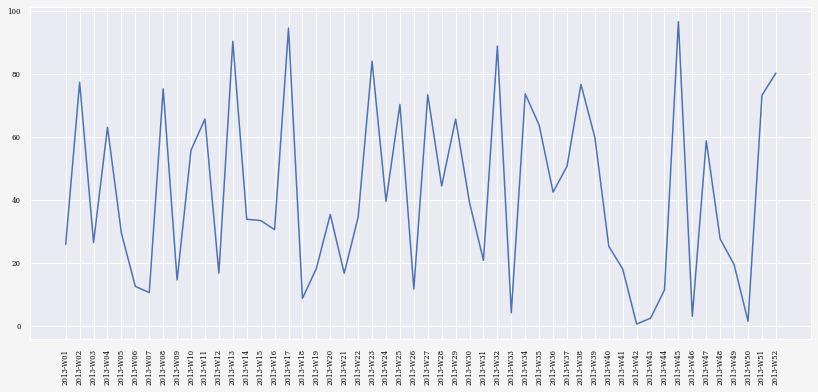

In [14]:
# Plot First year Prices
df_price_year = df_price.iloc[:52, :]

plt.figure(figsize =(14, 6))
plt.plot(df_price_year.index, df_price_year['Billboard 1'])
plt.xticks(rotation=90)
plt.locator_params(axis='x', nbins=10)

### <p style="padding: 15px; background-color: #778899; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">2.3 Data Seasonal Decomposition</p>

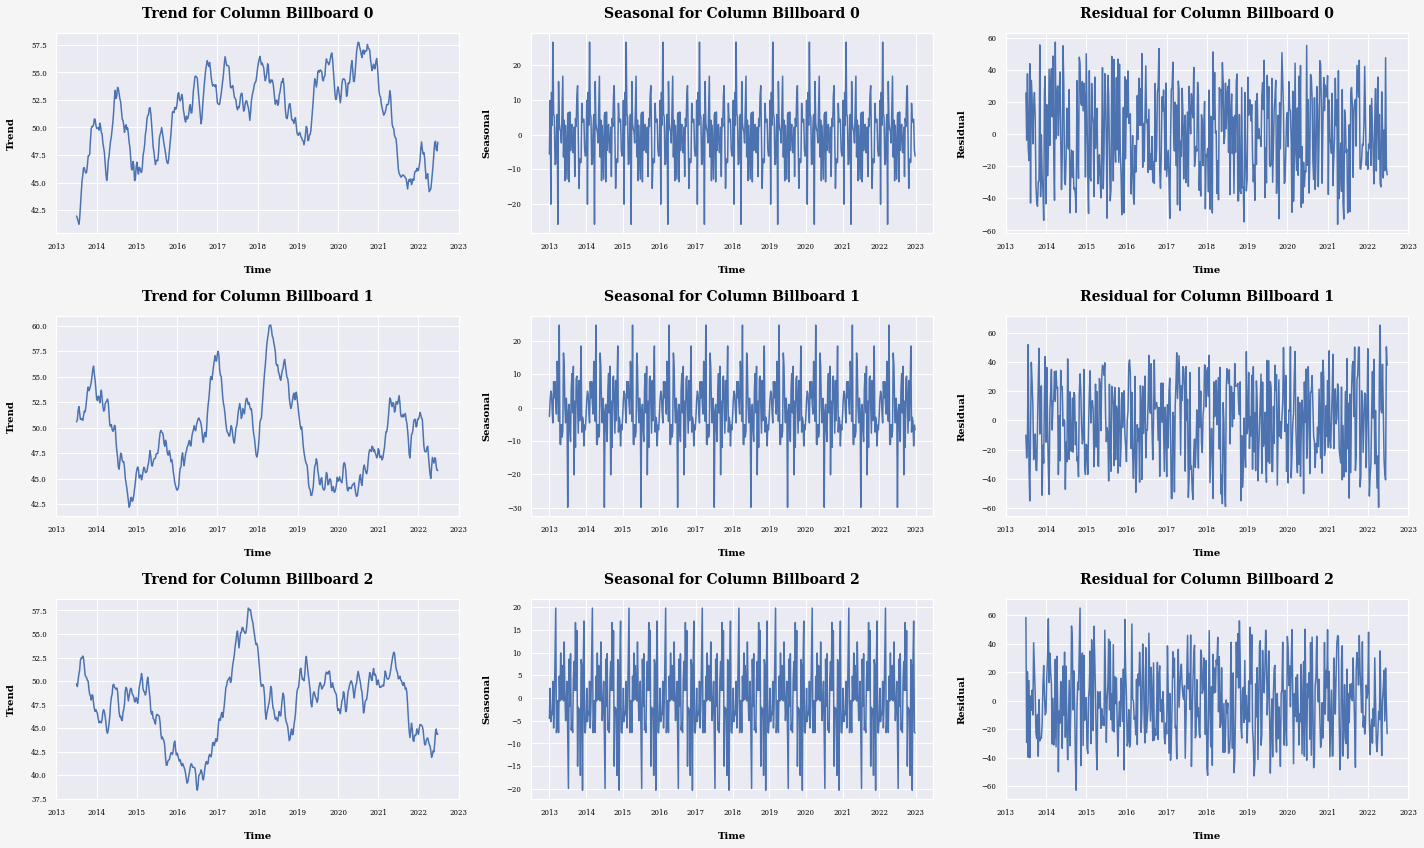

In [15]:
f, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 12))
ax = ax.flatten()

start_year = 2013
end_year = 2023

# Plotting loop for the first 3 columns, each column has 3 plots for decomposition
for i in range(3):
    # Decompose the time series in column i
    result = seasonal_decompose(df_price.iloc[:, i], model='additive', period=52)

    # Define the years for x-ticks
    years = range(start_year, end_year + 1)
    ticks = [52 * (year - start_year) for year in years]  # 52 weeks/year

    # Plot the trend component
    ax[i * 3].plot(result.trend)
    ax[i * 3].set_title(f'Trend for Column Billboard {i}')
    ax[i * 3].set_xlabel('Time')
    ax[i * 3].set_ylabel('Trend')
    ax[i * 3].set_xticks(ticks)
    ax[i * 3].set_xticklabels(years)

    # Plot the seasonal component
    ax[i * 3 + 1].plot(result.seasonal)
    ax[i * 3 + 1].set_title(f'Seasonal for Column Billboard {i}')
    ax[i * 3 + 1].set_xlabel('Time')
    ax[i * 3 + 1].set_ylabel('Seasonal')
    ax[i * 3 + 1].set_xticks(ticks)
    ax[i * 3 + 1].set_xticklabels(years)

    # Plot the residual component
    ax[i * 3 + 2].plot(result.resid)
    ax[i * 3 + 2].set_title(f'Residual for Column Billboard {i}')
    ax[i * 3 + 2].set_xlabel('Time')
    ax[i * 3 + 2].set_ylabel('Residual')
    ax[i * 3 + 2].set_xticks(ticks)
    ax[i * 3 + 2].set_xticklabels(years)

plt.tight_layout()
plt.show()


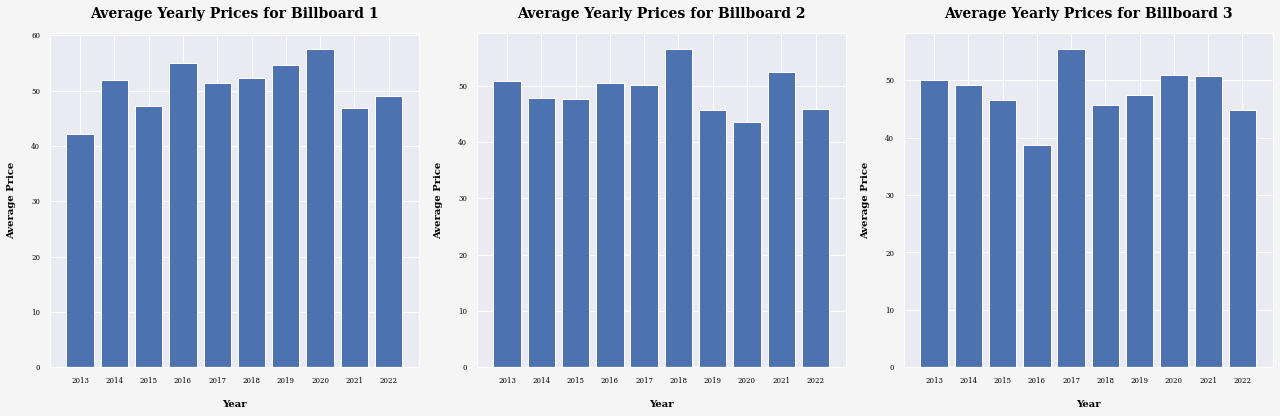

In [16]:
df_price['Year'] = df_price.index.str[:4]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Loop through the first three columns and plot their yearly means on separate subplots
for i in range(3):
    # Group by year and calculate mean for the current column
    yearly_means = df_price.groupby('Year')[df_price.columns[i]].mean()

    # Plotting yearly means on the i-th subplot
    axes[i].bar(yearly_means.index, yearly_means.values)
    axes[i].set_title(f'Average Yearly Prices for {df_price.columns[i]}')
    axes[i].set_ylabel('Average Price')
    axes[i].set_xlabel('Year')


plt.tight_layout()
plt.show()

### <p style="padding: 15px; background-color: #778899; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">2.4 Encoding Cyclical Features</p>

In [17]:
df_eng = df_price.copy()

df_eng.index = pd.to_datetime(df_eng.index + '-1', format='%G-W%V-%u')

df_eng['year'] = df_eng.index.year
df_eng['month'] = df_eng.index.month
df_eng['week_of_year'] = df_eng.index.isocalendar().week
df_eng['quarter'] = df_eng.index.quarter
df_eng['season'] = df_eng['month'] % 12 // 3 + 1
df_eng['month_sin'] = np.sin(2 * np.pi * df_eng['month'] / 12)
df_eng['month_cos'] = np.cos(2 * np.pi * df_eng['month'] / 12)

display(df_eng)

,Billboard 1,Billboard 2,Billboard 3,Billboard 4,Billboard 5,Billboard 6,Billboard 7,Billboard 8,Billboard 9,Billboard 10,...,Billboard 9999,Billboard 10000,Year,year,month,week_of_year,quarter,season,month_sin,month_cos
Week,,,,,,,,,,,,,,,,,,,,,
2012-12-31,25.820683,60.561442,64.778419,43.513197,9.023792,92.877623,90.395609,66.300510,51.869329,16.803929,...,63.364405,5.567435,2013,2012,12,1,4,1,-2.449294e-16,1.000000
2013-01-07,77.290307,44.098641,63.790161,20.583513,34.069329,0.750804,65.350084,77.432003,68.447205,51.071243,...,66.289973,48.562830,2013,2013,1,2,1,1,5.000000e-01,0.866025
2013-01-14,26.429772,12.864575,4.268997,51.335440,42.200420,40.437912,86.693324,49.920105,67.514653,49.626066,...,2.139296,0.947774,2013,2013,1,3,1,1,5.000000e-01,0.866025
2013-01-21,62.995948,22.159317,99.117024,88.960138,54.540406,34.568806,3.369170,51.443121,58.864645,3.889462,...,17.427074,5.499385,2013,2013,1,4,1,1,5.000000e-01,0.866025
2013-01-28,29.367953,66.752116,10.377996,10.176719,9.604717,40.637761,51.639044,42.440401,17.320294,48.937212,...,64.098923,43.775530,2013,2013,1,5,1,1,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-28,98.598690,96.440737,86.836562,41.154463,38.642059,65.806430,28.383626,14.972092,20.774558,28.712812,...,15.105104,43.918489,2022,2022,11,48,4,4,-5.000000e-01,0.866025
2022-12-05,66.285251,8.402181,76.917444,9.927406,12.619114,33.724980,2.994549,4.969539,62.692123,80.140140,...,70.769743,6.143603,2022,2022,12,49,4,1,-2.449294e-16,1.000000
2022-12-12,10.438122,29.320141,33.868714,95.511716,58.144501,43.962978,64.058752,67.743759,68.614345,94.950748,...,73.167186,38.286644,2022,2022,12,50,4,1,-2.449294e-16,1.000000


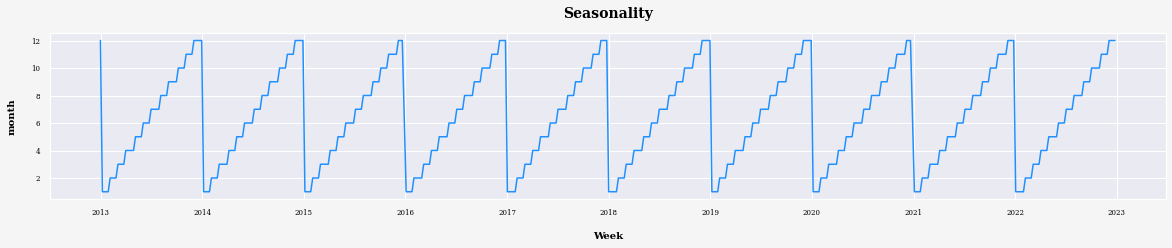

In [18]:
# Ploting Seasonality
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df_eng.index, y=df_eng['month'], color='dodgerblue')
plt.title('Seasonality')
plt.show()

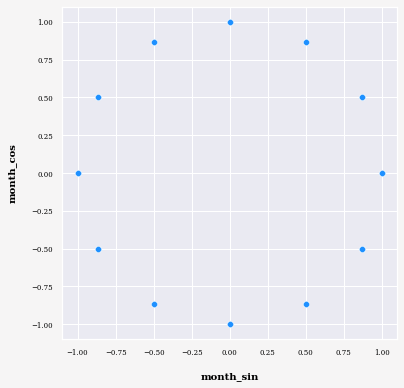

In [19]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df_eng.month_sin, y=df_eng.month_cos, color='dodgerblue')
plt.show()

### <p style="padding: 15px; background-color: #778899; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">2.5 Train Test Spliting</p>

In [20]:
N_SPLITS = 3

X = df_eng.index
y = df_eng['Billboard 1']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

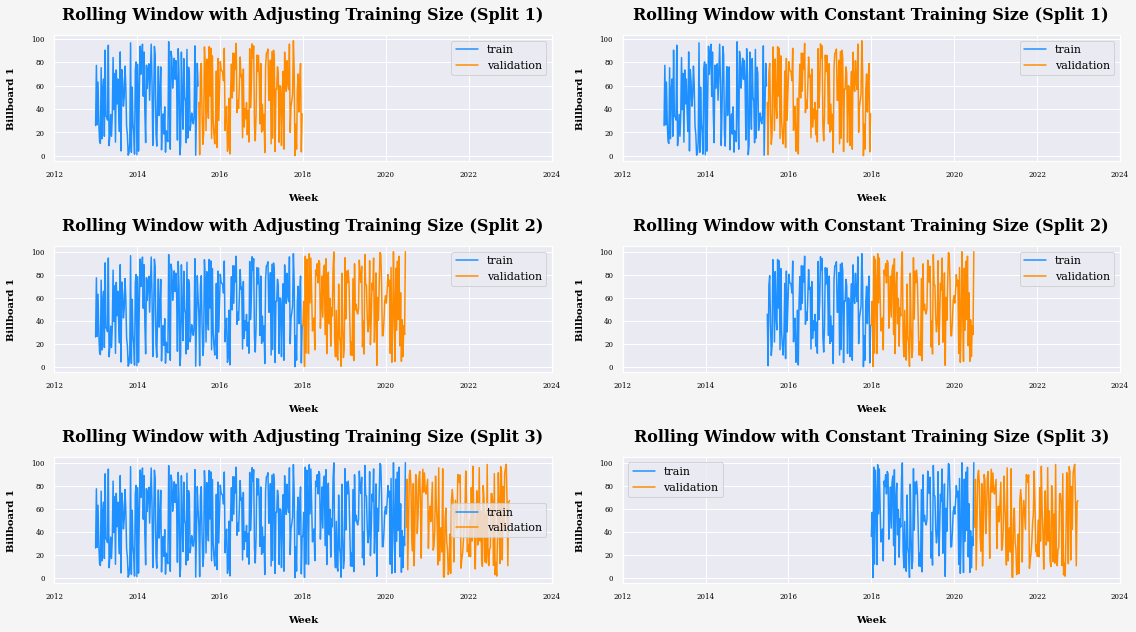

In [21]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train,
        y=y_train,
        ax=ax[i,0],
        color='dodgerblue',
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))],
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))],
        ax=ax[i,1],
        color='dodgerblue',
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2012, 1, 1), date(2024, 1, 1)])
    ax[i, 1].set_xlim([date(2012, 1, 1), date(2024, 1, 1)])



plt.tight_layout()
plt.show()

## <p style="padding: 15px; background-color: #778899; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 125%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">3) Feature Engineering</p>

<p style="
    font-size: 26px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #778899;
">
    <b>Notes</b> 📜
</p>

<blockquote style="
    margin-right: auto;
    margin-left: auto;
    background-color:#222;
    padding: 15px;
    border-radius: 8px;
    border-left: none;
">
<ul style="
    font-size: 18px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px;
    margin-bottom: 10px;
">
    <li style='padding-bottom: 10px;'><code>Data Engineering:</code> This section processes and transforms a dataset containing booking and price information for billboards. It initially merges and manipulates data from multiple sources, extracting key features from tuples, generating new columns for prices and booking ratios, and handling data formatting as one-hot encoding and date range creation. It enriches the dataset with temporal features like the month, week, and trigonometric representations of time to facilitate deeper time series analysis, all while maintaining a focus on readability and structure in the final dataset presentation.</li>
    <li style='padding-bottom: 10px;'><code>Data Scaling:</code> This section normalizes selected geographical and temporal features in a DataFrame to a uniform scale using MinMaxScaler, specifically adjusting longitude, latitude, year, and price data, while also transforming sine and cosine values of the month to range between 0 and 1 to facilitate model training or further analysis.</li>
    <li style='padding-bottom: 10px;'><code>Data Split:</code> This code splits the DataFrame into two: df containing entries with non-missing values for both 'Price' and 'Booking Ratio', and df_predictions specifically for entries where both 'Price' and 'Booking Ratio' are missing, presumably for later predictions.</li>
</ul>
</blockquote>


### <p style="padding: 15px; background-color: #778899; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">3.1 Data Engineering</p>

In [3]:
df = pd.concat([original_data, benchmarked_data], ignore_index=True)
df['Price_Booking521'] = '(None, None)' # Adding 1st Week for 2024

def extract_price(value):
    """
    Converts a string representation of a tuple into an actual tuple.

    Args:
        value (str): A string that represents a tuple, such as "(weekly_price, booking_ratio)".

    Returns:
        tuple: The actual tuple represented by the input string.
    """
    return ast.literal_eval(value)


# --------- Booking Price Column ---------
price_columns = [col for col in df.columns if 'Price_Booking' in col]

extract_price_bar = tqdm(price_columns, desc=f"{CYAN}Extracting Price", ascii="█▒")


for col in extract_price_bar:
      df[[f"{col[6:]}_price", f"{col[6:]}_ratio"]] = df[col].apply(extract_price).apply(pd.Series)

df.drop(price_columns, axis=1, inplace=True)


# --------- Billboard ID Column ---------
df.insert(0, 'Billboard ID', df.index.values) # adding Billboards ID

display(df)

Extracting Price: 100%|▒▒▒▒▒▒▒▒▒▒| 521/521 [03:46<00:00,  2.30it/s]


,Billboard ID,Long,Lat,Size,Light,Booking1_price,Booking1_ratio,Booking2_price,Booking2_ratio,Booking3_price,...,Booking517_price,Booking517_ratio,Booking518_price,Booking518_ratio,Booking519_price,Booking519_ratio,Booking520_price,Booking520_ratio,Booking521_price,Booking521_ratio
0,0,5,-54,medium,0,25.820683,0.7519,77.290307,0.1281,26.429772,...,66.285251,0.2090,10.438122,0.8847,65.584039,0.2190,67.036394,0.2070,None,None
1,1,15,34,large,1,60.561442,0.0441,44.098641,0.1872,12.864575,...,8.402181,0.8583,29.320141,0.4480,2.347874,0.9208,54.380550,0.0792,None,None
2,2,52,33,small,1,64.778419,0.0978,63.790161,0.1055,4.268997,...,76.917444,0.0374,33.868714,0.4942,0.415966,0.9249,91.441574,0.0103,None,None
3,3,36,-32,small,0,43.513197,0.5933,20.583513,0.8548,51.335440,...,9.927406,0.8888,95.511716,0.0999,15.339962,0.8736,58.671923,0.4038,None,None
4,4,29,49,medium,0,9.023792,0.9172,34.069329,0.6672,42.200420,...,12.619114,0.8676,58.144501,0.3303,62.250825,0.2868,54.831371,0.3759,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11995,54,46,large,0,38.920109,0.6391,43.671997,0.5828,79.310807,...,50.471020,0.4757,59.572979,0.3715,52.416580,0.4593,84.698754,0.1499,None,None
11996,11996,-33,30,small,1,63.414821,0.1132,96.525134,0.0070,48.693656,...,42.882098,0.3458,87.631624,0.0161,74.362602,0.0503,48.352662,0.2723,None,None
11997,11997,32,-44,large,1,78.756719,0.0079,85.837682,0.0032,94.063461,...,97.406043,0.0006,64.375040,0.0375,99.740069,0.0004,12.829507,0.8214,None,None
11998,11998,41,30,medium,0,9.971771,0.9119,43.748333,0.5274,76.780431,...,35.530568,0.6186,62.965042,0.2726,22.178777,0.7957,20.395285,0.8210,None,None


In [4]:
# Separate columns for price and booking ratios
price_columns = [col for col in df.columns if 'price' in col]
ratio_columns = [col for col in df.columns if 'ratio' in col]

# Melt the price columns
df_price = pd.melt(df, id_vars=['Billboard ID', 'Long', 'Lat', 'Size', 'Light'],
                   value_vars=price_columns,
                   var_name='Week',
                   value_name='Price')

# Melt the ratio columns
df_ratio = pd.melt(df, id_vars=['Billboard ID', 'Long', 'Lat', 'Size', 'Light'],
                   value_vars=ratio_columns,
                   var_name='Week',
                   value_name='Booking Ratio')

# Extract week numbers and correct column misalignments
df_price['Week'] = df_price['Week'].str.extract('(\d+)').astype(int)
df_ratio['Week'] = df_ratio['Week'].str.extract('(\d+)').astype(int)

# Merge the two DataFrames
df = pd.merge(df_price, df_ratio, on=['Billboard ID', 'Long', 'Lat', 'Size', 'Light', 'Week'])

# Sort by billboard ID and week for better organization
df = df.sort_values(by=['Billboard ID', 'Week'])
df = df.reset_index(drop=True)


display(df)

,Billboard ID,Long,Lat,Size,Light,Week,Price,Booking Ratio
0,0,5,-54,medium,0,1,25.820683,0.7519
1,0,5,-54,medium,0,2,77.290307,0.1281
2,0,5,-54,medium,0,3,26.429772,0.7555
3,0,5,-54,medium,0,4,62.995948,0.2545
4,0,5,-54,medium,0,5,29.367953,0.7252
...,...,...,...,...,...,...,...,...
6251995,11999,20,15,small,0,517,87.914796,0.0524
6251996,11999,20,15,small,0,518,55.927518,0.289
6251997,11999,20,15,small,0,519,58.752505,0.2585
6251998,11999,20,15,small,0,520,48.805807,0.3869


In [5]:
# --------- Size column ---------

# Perform one-hot encoding on the 'Size' column
size_dummies = pd.get_dummies(df['Size'], prefix='Size').astype(int)

# Find the index of the 'Light' column to insert new columns after it
light_col_index = df.columns.get_loc('Light') + 1

# Insert each column from size_dummies into df at the specified position
for size_col in size_dummies.columns:
    df.insert(loc=light_col_index, column=size_col, value=size_dummies[size_col])
    light_col_index += 1
    
df.drop(['Size'], axis=1, inplace=True)

display(df)

,Billboard ID,Long,Lat,Light,Size_large,Size_medium,Size_small,Week,Price,Booking Ratio
0,0,5,-54,0,0,1,0,1,25.820683,0.7519
1,0,5,-54,0,0,1,0,2,77.290307,0.1281
2,0,5,-54,0,0,1,0,3,26.429772,0.7555
3,0,5,-54,0,0,1,0,4,62.995948,0.2545
4,0,5,-54,0,0,1,0,5,29.367953,0.7252
...,...,...,...,...,...,...,...,...,...,...
6251995,11999,20,15,0,0,0,1,517,87.914796,0.0524
6251996,11999,20,15,0,0,0,1,518,55.927518,0.289
6251997,11999,20,15,0,0,0,1,519,58.752505,0.2585
6251998,11999,20,15,0,0,0,1,520,48.805807,0.3869


In [6]:
# Set the end date to the first day of the first ISO week of the ending year
end_date = '2024-01-01'

# Generate a date range ending on the end date for 521 weeks
dates = pd.date_range(end=end_date, periods=521, freq='W-MON')

# Check the first and last dates
first_date, last_date = dates[0], dates[-1]
print(f"{RED}First Date: {CYAN}{first_date}, {RED}Last Date: {CYAN}{last_date}")

print(dates)

First Date: 2014-01-13 00:00:00, Last Date: 2024-01-01 00:00:00
DatetimeIndex(['2014-01-13', '2014-01-20', '2014-01-27', '2014-02-03',
               '2014-02-10', '2014-02-17', '2014-02-24', '2014-03-03',
               '2014-03-10', '2014-03-17',
               ...
               '2023-10-30', '2023-11-06', '2023-11-13', '2023-11-20',
               '2023-11-27', '2023-12-04', '2023-12-11', '2023-12-18',
               '2023-12-25', '2024-01-01'],
              dtype='datetime64[ns]', length=521, freq='W-MON')


In [7]:
date_mapping = pd.Series(dates, index=range(1, 522))  # Create a mapping from week number to date

# Map this date series to your DataFrame
date_col = df['Week'].map(date_mapping)
df.insert(1, 'Date', date_col)
df.drop(['Week'], axis=1, inplace=True)

display(df)


,Billboard ID,Date,Long,Lat,Light,Size_large,Size_medium,Size_small,Price,Booking Ratio
0,0,2014-01-13,5,-54,0,0,1,0,25.820683,0.7519
1,0,2014-01-20,5,-54,0,0,1,0,77.290307,0.1281
2,0,2014-01-27,5,-54,0,0,1,0,26.429772,0.7555
3,0,2014-02-03,5,-54,0,0,1,0,62.995948,0.2545
4,0,2014-02-10,5,-54,0,0,1,0,29.367953,0.7252
...,...,...,...,...,...,...,...,...,...,...
6251995,11999,2023-12-04,20,15,0,0,0,1,87.914796,0.0524
6251996,11999,2023-12-11,20,15,0,0,0,1,55.927518,0.289
6251997,11999,2023-12-18,20,15,0,0,0,1,58.752505,0.2585
6251998,11999,2023-12-25,20,15,0,0,0,1,48.805807,0.3869


In [8]:
# --------- Seasonal Features ---------

# Now you can extract datetime attributes
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['week_of_year'] = df['Date'].dt.isocalendar().week
df['quarter'] = df['Date'].dt.quarter
df['season'] = df['month'] % 12 // 3 + 1
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Pop the column and assign it back to move it to the end
column_to_move = df.pop('Price')
df['Price'] = column_to_move
column_to_move = df.pop('Booking Ratio')
df['Booking Ratio'] = column_to_move

display(df)

,Billboard ID,Date,Long,Lat,Light,Size_large,Size_medium,Size_small,year,month,week_of_year,quarter,season,month_sin,month_cos,Price,Booking Ratio
0,0,2014-01-13,5,-54,0,0,1,0,2014,1,3,1,1,5.000000e-01,0.866025,25.820683,0.7519
1,0,2014-01-20,5,-54,0,0,1,0,2014,1,4,1,1,5.000000e-01,0.866025,77.290307,0.1281
2,0,2014-01-27,5,-54,0,0,1,0,2014,1,5,1,1,5.000000e-01,0.866025,26.429772,0.7555
3,0,2014-02-03,5,-54,0,0,1,0,2014,2,6,1,1,8.660254e-01,0.500000,62.995948,0.2545
4,0,2014-02-10,5,-54,0,0,1,0,2014,2,7,1,1,8.660254e-01,0.500000,29.367953,0.7252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6251995,11999,2023-12-04,20,15,0,0,0,1,2023,12,49,4,1,-2.449294e-16,1.000000,87.914796,0.0524
6251996,11999,2023-12-11,20,15,0,0,0,1,2023,12,50,4,1,-2.449294e-16,1.000000,55.927518,0.289
6251997,11999,2023-12-18,20,15,0,0,0,1,2023,12,51,4,1,-2.449294e-16,1.000000,58.752505,0.2585
6251998,11999,2023-12-25,20,15,0,0,0,1,2023,12,52,4,1,-2.449294e-16,1.000000,48.805807,0.3869


### <p style="padding: 15px; background-color: #778899; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">3.2 Data Scaling</p>

In [9]:
# Initialize the scaler
scaler_cols = MinMaxScaler(feature_range=(0, 1))
scaler_price = MinMaxScaler(feature_range=(0, 1))

# Columns to scale
columns_to_scale = ['Long', 'Lat', 'year']


# Fit and transform the training data
df[columns_to_scale] = scaler_cols.fit_transform(df[columns_to_scale])
df['Price'] = scaler_price.fit_transform(df[['Price']])

df['month_sin'] = (df['month_sin'] + 1) / 2  # shifts range from [-1, 1] to [0, 1]
df['month_cos'] = (df['month_cos'] + 1) / 2  # shifts range from [-1, 1] to [0, 1]


display(df)

,Billboard ID,Date,Long,Lat,Light,Size_large,Size_medium,Size_small,year,month,week_of_year,quarter,season,month_sin,month_cos,Price,Booking Ratio
0,0,2014-01-13,0.541667,0.050,0,0,1,0,0.0,1,3,1,1,0.750000,0.933013,0.258207,0.7519
1,0,2014-01-20,0.541667,0.050,0,0,1,0,0.0,1,4,1,1,0.750000,0.933013,0.772903,0.1281
2,0,2014-01-27,0.541667,0.050,0,0,1,0,0.0,1,5,1,1,0.750000,0.933013,0.264298,0.7555
3,0,2014-02-03,0.541667,0.050,0,0,1,0,0.0,2,6,1,1,0.933013,0.750000,0.629959,0.2545
4,0,2014-02-10,0.541667,0.050,0,0,1,0,0.0,2,7,1,1,0.933013,0.750000,0.293680,0.7252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6251995,11999,2023-12-04,0.666667,0.625,0,0,0,1,0.9,12,49,4,1,0.500000,1.000000,0.879148,0.0524
6251996,11999,2023-12-11,0.666667,0.625,0,0,0,1,0.9,12,50,4,1,0.500000,1.000000,0.559275,0.289
6251997,11999,2023-12-18,0.666667,0.625,0,0,0,1,0.9,12,51,4,1,0.500000,1.000000,0.587525,0.2585
6251998,11999,2023-12-25,0.666667,0.625,0,0,0,1,0.9,12,52,4,1,0.500000,1.000000,0.488058,0.3869


### <p style="padding: 15px; background-color: #778899; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">3.3 Data Split</p>

In [10]:
df_all = df.copy()

df_predictions = df[(df['Price'].isna()) & (df['Booking Ratio'].isna())].copy()
df = df[~(df['Price'].isna() & df['Booking Ratio'].isna())]

display(df, df_predictions)

,Billboard ID,Date,Long,Lat,Light,Size_large,Size_medium,Size_small,year,month,week_of_year,quarter,season,month_sin,month_cos,Price,Booking Ratio
0,0,2014-01-13,0.541667,0.050,0,0,1,0,0.0,1,3,1,1,0.750000,0.933013,0.258207,0.7519
1,0,2014-01-20,0.541667,0.050,0,0,1,0,0.0,1,4,1,1,0.750000,0.933013,0.772903,0.1281
2,0,2014-01-27,0.541667,0.050,0,0,1,0,0.0,1,5,1,1,0.750000,0.933013,0.264298,0.7555
3,0,2014-02-03,0.541667,0.050,0,0,1,0,0.0,2,6,1,1,0.933013,0.750000,0.629959,0.2545
4,0,2014-02-10,0.541667,0.050,0,0,1,0,0.0,2,7,1,1,0.933013,0.750000,0.293680,0.7252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6251994,11999,2023-11-27,0.666667,0.625,0,0,0,1,0.9,11,48,4,4,0.250000,0.933013,0.956568,0.0308
6251995,11999,2023-12-04,0.666667,0.625,0,0,0,1,0.9,12,49,4,1,0.500000,1.000000,0.879148,0.0524
6251996,11999,2023-12-11,0.666667,0.625,0,0,0,1,0.9,12,50,4,1,0.500000,1.000000,0.559275,0.289
6251997,11999,2023-12-18,0.666667,0.625,0,0,0,1,0.9,12,51,4,1,0.500000,1.000000,0.587525,0.2585


,Billboard ID,Date,Long,Lat,Light,Size_large,Size_medium,Size_small,year,month,week_of_year,quarter,season,month_sin,month_cos,Price,Booking Ratio
520,0,2024-01-01,0.541667,0.050000,0,0,1,0,1.0,1,1,1,1,0.75,0.933013,NaN,None
1041,1,2024-01-01,0.625000,0.783333,1,1,0,0,1.0,1,1,1,1,0.75,0.933013,NaN,None
1562,2,2024-01-01,0.933333,0.775000,1,0,0,1,1.0,1,1,1,1,0.75,0.933013,NaN,None
2083,3,2024-01-01,0.800000,0.233333,0,0,0,1,1.0,1,1,1,1,0.75,0.933013,NaN,None
2604,4,2024-01-01,0.741667,0.908333,0,0,1,0,1.0,1,1,1,1,0.75,0.933013,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6249915,11995,2024-01-01,0.950000,0.883333,0,1,0,0,1.0,1,1,1,1,0.75,0.933013,NaN,None
6250436,11996,2024-01-01,0.225000,0.750000,1,0,0,1,1.0,1,1,1,1,0.75,0.933013,NaN,None
6250957,11997,2024-01-01,0.766667,0.133333,1,1,0,0,1.0,1,1,1,1,0.75,0.933013,NaN,None
6251478,11998,2024-01-01,0.841667,0.750000,0,0,1,0,1.0,1,1,1,1,0.75,0.933013,NaN,None


## <p style="padding: 15px; background-color: #778899; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 125%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">4) Modeling</p>

<p style="
    font-size: 26px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #778899;
">
    <b>Notes</b> 📜
</p>

<blockquote style="
    margin-right: auto;
    margin-left: auto;
    background-color:#222;
    padding: 15px;
    border-radius: 8px;
    border-left: none;
">
<ul style="
    font-size: 18px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px;
    margin-bottom: 10px;
">
    <li style='padding-bottom: 10px;'><code>CPU/GPU Support:</code> This code snippet checks for the availability of CUDA and MPS backends to determine the appropriate computing device for PyTorch operations, defaulting to CPU if neither are available</li>
    <li style='padding-bottom: 10px;'><code>Neural Network (PyTorch):</code> This comprehensive script sets up and trains a neural network model for predicting booking ratios, using PyTorch and custom dataset management. It defines a `BookingRatioNet` class for the model, a `BillboardDataset` for handling the data, and functions for data loading, training, validation, testing, and visualizing learning curves. The training process includes detailed tracking and updates of training and validation losses, with the ability to save the best model based on validation performance. After training, it plots the loss curves to visualize training dynamics and evaluates the model on a test set, calculating metrics like MSE, RMSE, and MAE to assess performance.</li>
    <li style='padding-bottom: 10px;'><code>Predicting on Benchmarked Data:</code> This section of the code is designed to optimize revenue by predicting the most profitable price points using a trained neural network model. It loads a pre-trained model and evaluates a range of price points for the last 2000 entries in the df_predictions DataFrame. Using the DataLoader setup get_dls2, it iteratively calculates potential revenues by combining predicted booking ratios with corresponding prices. The code then selects the optimal price and ratio that yield the highest revenue for each entry, updating the DataFrame with these optimal values, reversing any previous normalization on scaled columns, and calculating the maximum possible revenue.</li>
</ul>
</blockquote>


### <p style="padding: 15px; background-color: #778899; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">4.1 CPU/GPU Support</p>

In [11]:
print("PyTorch version:", torch.__version__)


if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"{CYAN}Using device: {RED}{device}")
    print(torch.cuda.get_device_name(0))
    
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"{CYAN}Using device: {RED}{device}")
    print(f"{CYAN}Running on the GPU")
    
else:
    device = torch.device("cpu")
    print(f"{CYAN}Running on the {RED}CPU")

PyTorch version: 2.2.0
Running on the CPU


### <p style="padding: 15px; background-color: #778899; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">4.2 Neural Network (PyTorch)</p>

In [12]:
class BookingRatioNet(nn.Module):
    """
    Defines a neural network for predicting booking ratios using a sequence of linear layers and activations.
    Incorporates dropout for regularization and a sigmoid output for ratio predictions between 0 and 1.

    Attributes:
        fc1 to fc4 (nn.Linear): Sequential fully connected layers.
        relu (nn.ReLU): ReLU activation function for non-linear transformations.
        sigmoid (nn.Sigmoid): Sigmoid activation for producing the final output.
        dropout (nn.Dropout): Applies a dropout of 10% to prevent overfitting.
    """
    def __init__(self):
        super(BookingRatioNet, self).__init__()

        self.fc1 = nn.Linear(14, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        return x

In [13]:
class BillboardDataset(Dataset):
    """
    A custom dataset class for loading billboard data into a format compatible with PyTorch's DataLoader.

    Args:
        features: Input features for the dataset.
        labels: Corresponding labels for each feature set.
    """
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]



def get_dls(df, batch_size = 32):
    """
    Prepares and returns data loaders for training, validation, and testing sets from the input DataFrame.

    Args:
        df (DataFrame): The source DataFrame containing all the data.
        batch_size (int): The size of each batch of data for the data loaders.

    Returns:
        dict: A dictionary containing 'train', 'val', and 'test' DataLoader objects.
    """
    # First split: Separate training (70%) and temp (30%)
    train_df, df_temp = train_test_split(df, test_size=0.3, random_state=42)

    # Second split: Separate validation and test from temp (each 15% of the original dataset)
    val_df, test_df = train_test_split(df_temp, test_size=0.5, random_state=42)


    features = ['Long', 'Lat', 'Light', 'Size_large', 'Size_medium', 'Size_small',
                'year', 'month', 'week_of_year', 'quarter', 'season', 'month_sin', 'month_cos', 'Price']


    # Extracting the features and labels from train, validation, and test sets
    X_train = np.array(train_df[features], dtype=np.float32)
    y_train = np.array(train_df['Booking Ratio'], dtype=np.float32).reshape(-1, 1)

    X_val = np.array(val_df[features], dtype=np.float32)
    y_val = np.array(val_df['Booking Ratio'], dtype=np.float32).reshape(-1, 1)

    X_test = np.array(test_df[features], dtype=np.float32)
    y_test = np.array(test_df['Booking Ratio'], dtype=np.float32).reshape(-1, 1)


    X_train_tensor = torch.from_numpy(X_train)
    y_train_tensor = torch.from_numpy(y_train)

    X_val_tensor = torch.from_numpy(X_val)
    y_val_tensor = torch.from_numpy(y_val)

    X_test_tensor = torch.from_numpy(X_test)
    y_test_tensor = torch.from_numpy(y_test)


    train_dataset = BillboardDataset(X_train_tensor, y_train_tensor)
    val_dataset = BillboardDataset(X_val_tensor, y_val_tensor)
    test_dataset = BillboardDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

    print(f"{CYAN}len train_loader: {RED}{len(train_loader)}{CYAN}, Items: {RED}{len(train_loader) * batch_size}")
    print(f"{CYAN}len val_loader: {RED}{len(val_loader)}{CYAN}, Items: {RED}{len(val_loader) * batch_size}")
    print(f"{CYAN}len test_loader: {RED}{len(test_loader)}{CYAN}, Items: {RED}{len(test_loader) * 1}")

    data_loaders = {"train": train_loader, "val": val_loader, "test": test_loader}

    return data_loaders

In [14]:
# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.0001

data_loaders = get_dls(df, batch_size=BATCH_SIZE)

model = BookingRatioNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

len train_loader: 136500, Items: 4368000
len val_loader: 29250, Items: 936000
len test_loader: 936000, Items: 936000


Start Training ...


Validation: Epoch [3/3]: 100%|▒▒▒▒▒▒▒▒▒▒| 29250/29250 [00:26<00:00, 1097.51it/s, Loss: 0.01]


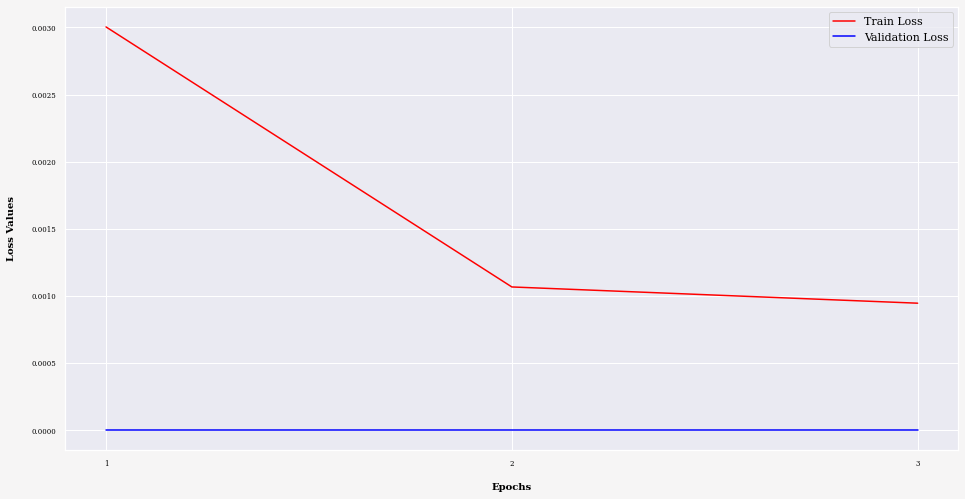

Test:: 100%|▒▒▒▒▒▒▒▒▒▒| 936000/936000 [04:53<00:00, 3192.44it/s]


MSE: 0.001
RMSE: 0.024
MAE: 0.017


In [45]:
def train(model, device, train_loader, optimizer, criterion, epoch, epochs):
      """
      Trains the model for one epoch, tracking and reporting the loss at each step.

      Args:
            model (nn.Module): The neural network model to train.
            device (torch.device): The device (CPU or GPU) to train the model on.
            train_loader (DataLoader): DataLoader providing batches of training data.
            optimizer (torch.optim): Optimizer used for updating model weights.
            criterion (loss function): Loss function used to evaluate the model.
            epoch (int): The current epoch number.
            epochs (int): Total number of epochs to train.

      Returns:
            float: The average loss for this training epoch.
      """
      model.train()
      epoch_loss = 0.0
      n_total_steps = len(train_loader)
      train_progress_bar = tqdm(enumerate(train_loader),
                                total=n_total_steps,
                                desc=f"{CYAN}Train: {RED}Epoch {CYAN}[{epoch+1}/{epochs}]",
                                leave=True,
                                ascii="█▒")

      for i, (inputs, labels) in train_progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Accumulate loss
            epoch_loss += loss.item()

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update progress bar with the latest loss
            train_progress_bar.set_postfix({"loss": loss.item()})

      train_loss_to_track = epoch_loss / n_total_steps

      return train_loss_to_track


def validation(model, device, val_loader, criterion, best_val_loss, epoch, epochs):
      """
      Evaluates the model on the validation set, optionally saving the model if performance improves.

      Args:
            model (nn.Module): The model to evaluate.
            device (torch.device): Device to perform computation on.
            val_loader (DataLoader): DataLoader for the validation data.
            criterion (function): Function to compute the loss.
            best_val_loss (float): The best validation loss observed so far.
            epoch (int): Current epoch number.
            epochs (int): Total number of epochs for training.

      Returns:
            float: The average loss for this validation epoch.
            float: Updated best validation loss.
      """
      model.eval()
      val_epoch_loss = 0
      save_prefix, save_dir, threshold = "main_5", "saved_models", 0.0001
      n_total_steps = len(val_loader)

      val_progress_bar = tqdm(enumerate(val_loader),
                              total=n_total_steps,
                              desc=f"{CYAN}Validation: {RED}Epoch {CYAN}[{epoch+1}/{epochs}]",
                              ascii="█▒",
                              leave=True,
                              postfix="\x1b[31m" + "Loss: 0.01" + "\x1b[0m")

      with torch.no_grad():

            for idx, (inputs, labels) in val_progress_bar:
                  inputs, labels = inputs.to(device) , labels.to(device)

                  preds = model(inputs)
                  loss = criterion(preds, labels)


                  if loss.item() < (best_val_loss + threshold):
                    os.makedirs(save_dir, exist_ok=True)
                    best_val_loss = loss.item()
                    torch.save(model.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")


      val_loss_to_track = val_epoch_loss / n_total_steps
      return val_loss_to_track, best_val_loss


def learning_curves(train_losses, val_losses):
      """
      Plots the training and validation loss curves over epochs.

      Args:
            train_losses (list): List of training losses for each epoch.
            val_losses (list): List of validation losses for each epoch.
      """  
      plt.figure(figsize=(16, 8))
      plt.plot(train_losses, label="Train Loss", c="red")
      plt.plot(val_losses, label="Validation Loss", c="blue")
      plt.xlabel("Epochs")
      plt.ylabel("Loss Values")
      plt.xticks(
            ticks=np.arange(len(train_losses)),
            labels=[i for i in range(1, len(train_losses) + 1)],
      )
      plt.legend()
      plt.show()


def test(device, test_loader):
      """
      Evaluates the model on the test dataset and prints out mean squared error (MSE), 
      root mean squared error (RMSE), and mean absolute error (MAE).

      Args:
            device (torch.device): The device (CPU or GPU) on which to perform the evaluation.
            test_loader (DataLoader): DataLoader providing batches of test data.
      """
      predictions = []
      test_labels = []

      model.load_state_dict(torch.load('saved_models/main_5(2)_best_model.pth'))
      model.eval()
      n_total_steps = len(test_loader)
      test_progress_bar = tqdm(enumerate(test_loader),
                              total=n_total_steps,
                              desc=f"{CYAN}Test:",
                              ascii="█▒",
                              leave=True)

      with torch.no_grad():

            for idx, (inputs, labels) in test_progress_bar:
                  inputs, labels = inputs.to(device) , labels.to(device)

                  preds = model(inputs)

                  predictions.append(np.array(preds.cpu())[0][0])
                  test_labels.append(np.array(labels.cpu())[0][0])



      predictions = np.array(predictions)
      test_labels = np.array(test_labels)


      # Calculate RMSE and MAE
      mse = mean_squared_error(predictions, test_labels)
      rmse = np.sqrt(mse)
      mae = mean_absolute_error(predictions, test_labels)
      print(f"{CYAN}MSE: {RED}{mse:.3f}")
      print(f"{CYAN}RMSE: {RED}{rmse:.3f}")
      print(f"{CYAN}MAE: {RED}{mae:.3f}")



def optimize_model(data_loaders, model, optimizer, criterion, device, epochs=10):
      """
      Orchestrates the training, validation, and testing of the model across specified epochs.

      Args:
            data_loaders (dict): Contains DataLoaders for training, validation, and testing.
            model (nn.Module): The model to train and evaluate.
            optimizer (torch.optim.Optimizer): The optimizer for model parameter updates.
            criterion (callable): The loss function used for model training.
            device (torch.device): The device (CPU or GPU) to run the model on.
            epochs (int, optional): The number of epochs to train the model. Defaults to 10.

      The function manages the training and validation process, tracks and plots loss, and finally tests the model performance.
      """
      train_loader = data_loaders['train']
      val_loader = data_loaders['val']
      test_loader = data_loaders['test']

      best_val_loss = float(torch.inf)
      train_losses, val_losses = [], []

      print(f'{CYAN}Start Training ...')

      for epoch in range(epochs):

            # ----- Train -----
            train_loss_to_track = train(model, device, train_loader, optimizer, criterion, epoch, epochs)
            train_losses.append(train_loss_to_track)


            # ----- Validation -----
            val_loss_to_track, best_val_loss = validation(model, device, val_loader, criterion, best_val_loss, epoch, epochs)
            val_losses.append(val_loss_to_track)




      # ----- Plot Losses -----
      learning_curves(train_losses, val_losses)

      # ----- Test -----
      test(device, test_loader)

optimize_model(data_loaders, model, optimizer, criterion, device, epochs = 5)

### <p style="padding: 15px; background-color: #778899; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">4.3 Predicting on Benchmarked Data</p>

In [15]:
df_predictions = df_predictions.iloc[-2000:, :] # benchmarked data
df_predictions

,Billboard ID,Date,Long,Lat,Light,Size_large,Size_medium,Size_small,year,month,week_of_year,quarter,season,month_sin,month_cos,Price,Booking Ratio
5210520,10000,2024-01-01,0.591667,0.433333,1,0,0,1,1.0,1,1,1,1,0.75,0.933013,NaN,None
5211041,10001,2024-01-01,0.308333,0.916667,0,1,0,0,1.0,1,1,1,1,0.75,0.933013,NaN,None
5211562,10002,2024-01-01,0.583333,0.125000,0,0,1,0,1.0,1,1,1,1,0.75,0.933013,NaN,None
5212083,10003,2024-01-01,0.466667,0.525000,1,0,0,1,1.0,1,1,1,1,0.75,0.933013,NaN,None
5212604,10004,2024-01-01,0.483333,0.625000,1,0,0,1,1.0,1,1,1,1,0.75,0.933013,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6249915,11995,2024-01-01,0.950000,0.883333,0,1,0,0,1.0,1,1,1,1,0.75,0.933013,NaN,None
6250436,11996,2024-01-01,0.225000,0.750000,1,0,0,1,1.0,1,1,1,1,0.75,0.933013,NaN,None
6250957,11997,2024-01-01,0.766667,0.133333,1,1,0,0,1.0,1,1,1,1,0.75,0.933013,NaN,None
6251478,11998,2024-01-01,0.841667,0.750000,0,0,1,0,1.0,1,1,1,1,0.75,0.933013,NaN,None


In [16]:
def get_dls2(df):
    """
    Creates and returns a DataLoader for the given DataFrame, assuming all data is either for prediction.

    Args:
        df (DataFrame): The DataFrame containing features and booking ratio labels.

    Returns:
        DataLoader: A DataLoader object configured for batch processing of size one, without shuffling.
    """
    features = ['Long', 'Lat', 'Light', 'Size_large', 'Size_medium', 'Size_small',
                'year', 'month', 'week_of_year', 'quarter', 'season', 'month_sin', 'month_cos', 'Price']


    # Extracting the features and labels from train, validation, and test sets
    X = np.array(df[features], dtype=np.float32)
    y = np.array(df['Booking Ratio'], dtype=np.float32).reshape(-1, 1)


    dataset = BillboardDataset(X, y)

    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

    print(f"len loader: {len(loader)}, Items: {len(loader) * 1}")

    return loader

In [17]:
def best_revenue(data, price_range):
      """
      Evaluates the best possible prices to maximize revenue based on a predictive model and a specified price range.

      Args:
            data (DataFrame): The dataset containing features for prediction.
            price_range (numpy array): An array of normalized price values to test for revenue optimization.

      Returns:
            tuple: Two numpy arrays containing the optimal prices and booking ratios that maximize revenue for each data point.
      """
      model.load_state_dict(torch.load('saved_models/main_5(2)_best_model.pth'))
      model.eval()

      loader = get_dls2(data)
      n_total_steps = len(loader)
      best_prices = []
      best_ratios = []

      progress_bar = tqdm(enumerate(loader),
                              total=n_total_steps,
                              desc=f"{CYAN}Predictions:",
                              ascii="█▒",
                              leave=True)

      with torch.no_grad():

            for id, (input, label) in progress_bar:
                  input, label = input.to(device) , label.to(device)
                  max_revenue = 0
                  optimal_price = 0
                  optimal_ratio = 0

                  for price in price_range:
                        # Update the price
                        input[0][-1] = price
                        # Predict the booking ratio
                        predicted_ratio = model(input)
                        predicted_ratio = np.array(predicted_ratio.cpu())[0][0]

                        original_price = scaler_price.inverse_transform(np.array(price).reshape(-1, 1))
                        original_price = original_price.ravel()[0]



                        revenue = original_price * predicted_ratio * 7

                        if revenue > max_revenue:
                              max_revenue = revenue
                              optimal_price = original_price
                              optimal_ratio = predicted_ratio


                  best_prices.append(optimal_price)
                  best_ratios.append(optimal_ratio)

      return np.array(best_prices).reshape(-1, 1), np.array(best_ratios).reshape(-1, 1)




price_range = np.linspace(start=0, stop=1, num=3000)

best_prices, best_ratios = best_revenue(df_predictions, price_range)


len loader: 2000, Items: 2000


Predictions:: 100%|▒▒▒▒▒▒▒▒▒▒| 2000/2000 [05:57<00:00,  5.59it/s]


In [18]:
df_predictions['Price'] = best_prices
df_predictions['Booking Ratio'] = best_ratios

df_predictions[columns_to_scale] = scaler_cols.inverse_transform(df_predictions[columns_to_scale])
df_predictions['Max Revenue'] = df_predictions['Price'] * df_predictions['Booking Ratio'] * 7

df_predictions

,Billboard ID,Date,Long,Lat,Light,Size_large,Size_medium,Size_small,year,month,week_of_year,quarter,season,month_sin,month_cos,Price,Booking Ratio,Max Revenue
5210520,10000,2024-01-01,11.0,-8.0,1,0,0,1,2024.0,1,1,1,1,0.75,0.933013,25.308436,0.608964,107.883510
5211041,10001,2024-01-01,-23.0,50.0,0,1,0,0,2024.0,1,1,1,1,0.75,0.933013,37.612537,0.554034,145.870291
5211562,10002,2024-01-01,10.0,-45.0,0,0,1,0,2024.0,1,1,1,1,0.75,0.933013,37.345782,0.611141,159.764884
5212083,10003,2024-01-01,-4.0,3.0,1,0,0,1,2024.0,1,1,1,1,0.75,0.933013,27.942647,0.543656,106.338290
5212604,10004,2024-01-01,-2.0,15.0,1,0,0,1,2024.0,1,1,1,1,0.75,0.933013,27.975992,0.555867,108.856599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6249915,11995,2024-01-01,54.0,46.0,0,1,0,0,2024.0,1,1,1,1,0.75,0.933013,41.280426,0.540695,156.240879
6250436,11996,2024-01-01,-33.0,30.0,1,0,0,1,2024.0,1,1,1,1,0.75,0.933013,28.976325,0.601834,122.072624
6250957,11997,2024-01-01,32.0,-44.0,1,1,0,0,2024.0,1,1,1,1,0.75,0.933013,26.042014,0.555602,101.283021
6251478,11998,2024-01-01,41.0,30.0,0,0,1,0,2024.0,1,1,1,1,0.75,0.933013,41.080360,0.554051,159.324295


In [25]:
output_benchmarked_data = pd.DataFrame(df_predictions.iloc[:, -3]).reset_index(drop=True)
output_benchmarked_data

,Price
0,25.308436
1,37.612537
2,37.345782
3,27.942647
4,27.975992
...,...
1995,41.280426
1996,28.976325
1997,26.042014
1998,41.080360


In [27]:
output_benchmarked_data.to_csv('output_benchmarked_data.csv', index=False)